# Lecture 19 - Gaussian Mixture Models (GMMs) continued; Performance Metrics

In [17]:
from scipy.stats import multivariate_normal
import numpy as np
import numpy.random as npr

import matplotlib.pyplot as plt
%matplotlib inline

# Gaussian Mixture Models

A **Gaussian Mixture Model** or **GMM** is a probabilistic model that assumes a data likelihood to be a weighted sum of Gaussian distributions with unknown parameters.

$$p(\mathbf{x}|\Theta) = \sum_{k=1}^K \pi_k N(\mathbf{x}|\mathbf{\mu}_k,\Sigma_k)$$

where $\Theta=\{\pi_k, \mu_k, \Sigma_k\}_{k=1}^K$, $0 \leq \pi_k \leq 1$ and $\sum_{k=1}^K \pi_k = 1$.

* When standard distributions (such as Gamma, Exponential, Gaussian, etc.) are not sufficient to characterize a *complicated* data likelihood, we can instead characterize it as the sum of weighted Gaussians distributions

* Another way that GMMs are most commonly used for is to partition data in subgroups

## Implementation - Pseudo-Code

We now have everything we need to implement the EM algorithm for Gaussian Mixtures.

* The pseudo-code for the algorithm is:

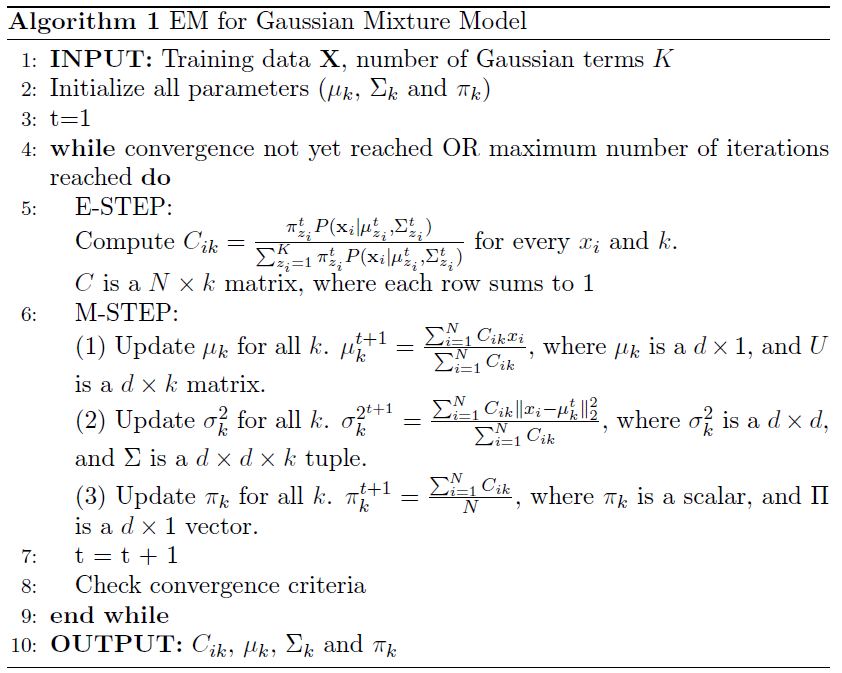

In [18]:
from IPython.display import Image
Image('figures/PseudoCode_EMforGMM.png',width=700)

## Alternating Optimization

* Does the EM algorithm find the **global minima**?

* Given a data set with an unknown number of groups/clusters, can you come up with a strategy for determining the "right" number of groups?

## Example: GMM as Data Likelihood Estimation or Clustering Algorithm

GMM is commonly used as an algorithm for density estimation. That is to say, the result of a GMM fit to some data is technically not a clustering model, but a generative probabilistic model describing the distribution of the data.

However, a common practical use for the GMM is as a clustering algorithm, where we are interested in finding groups in the data.

## Simulating Gaussian Mixture Models

**<font color=blue>Exercise:</font> In code, how would you draw a sample from a Gaussian Mixture Model? Or from a mixture model in general?**

* Note that in a Gaussian Mixture Model we are assuming that each data point $x_i$ was drawn from only one Gaussian. 

* Each data point $x_i$ has a *hard membership*.

* Each Gaussian in the Mixture Model will have its own $0 \leq \pi_k \leq 1$.

To simulate an event with arbitary probability $P_E$:

1. Generate a random number R that is equally likely to be between 0 and 1.

2. If $R \le P_E$, then in the simulation, the event occurs. Otherwise it does not occur.

In [19]:
import numpy.random as npr

In [20]:
?npr.uniform

In [21]:
# Example simulation
Pe=0.13

num_sims=100_000
event_count=0
for sim in range(num_sims):
    if npr.uniform()<=Pe:
        event_count+=1
    
        
print('According to the simulation Pe =~',event_count/num_sims)

According to the simulation Pe =~ 0.12953


Let's consider the case where we have 4 Gaussian in the Mixture model with weights $[0.4,0.25,0.25,0.1]$:

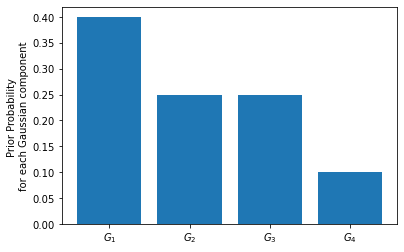

In [22]:
Pis = [.4, .25, .25, .1]

plt.bar(range(1,5), Pis)
plt.xticks(range(1,5),['$G_1$','$G_2$','$G_3$','$G_4$'])
plt.ylabel('Prior Probability \nfor each Gaussian component');

We need to first (randomly) select a Gaussian and then draw a point from it.

* How do you select from this set of Gaussians?

* We can sum up the $\pi$'s as we move from left to right and plot the running sums (or cumulative sum), then we can sample a Gaussian using a Uniform random number generator.

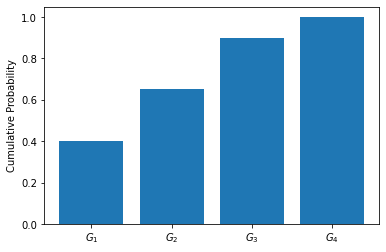

In [23]:
plt.bar(range(1,5), np.cumsum(Pis))
plt.xticks(range(1,5),['$G_1$','$G_2$','$G_3$','$G_4$'])
plt.ylabel('Cumulative Probability');

In [24]:
rv = npr.uniform()
print(rv)

0.8753690268926574


In [25]:
rv <= np.cumsum(Pis)

array([False, False,  True,  True])

In [26]:
np.where(rv <= np.cumsum(Pis))[0][0]

2

Putting it all together:

In [31]:
def make_GaussianMixture(N, Means, Sigs, Pis):
    X = np.empty((0,Means.shape[1]))
    L = np.empty(0)
    print(Pis)
    for i in range(N):
        rv = npr.uniform()   # sample uniform RV
        
        GaussianChosen = np.where(rv < np.cumsum(Pis))[0][0]
        L = np.append(L, GaussianChosen)
        X = np.append(X, np.array([npr.multivariate_normal(Means[GaussianChosen], 
                                                           np.eye(Means.shape[1])*Sigs[GaussianChosen])]), axis=0)
       
    return X, L


[0.4, 0.25, 0.25, 0.1]
[2. 0. 0. ... 1. 1. 3.]


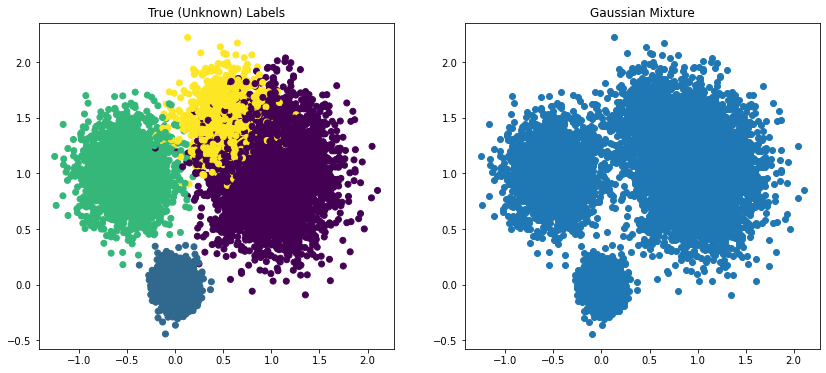

In [32]:
N = 10_000
Means = np.array([[1,1],[0,0],[-.5, 1],[.5, 1.5]])
Sigs = [.1, .01, .05, .05]
Pis = [.4, .25, .25, .1]

X,L = make_GaussianMixture(N, Means, Sigs, Pis)
print(L)
fig = plt.figure(figsize=(14,6))
fig.add_subplot(1,2,1)
plt.scatter(X[:,0],X[:,1], c=L)
plt.title('True (Unknown) Labels');
fig.add_subplot(1,2,2)
plt.scatter(X[:,0],X[:,1])
plt.title('Gaussian Mixture');

The picture on the left, represents the entire data color-coded according to a class they belong to.

In practice we are **not** given labels, and so we work directly with the unlabeled data set on the right.

* We can use GMM to uncover groups in the data.

To illustrate this, I will use the ```scikit-learn``` algorithm implementation of the GMM model:

In [14]:
from sklearn.mixture import GaussianMixture

In [15]:
?GaussianMixture

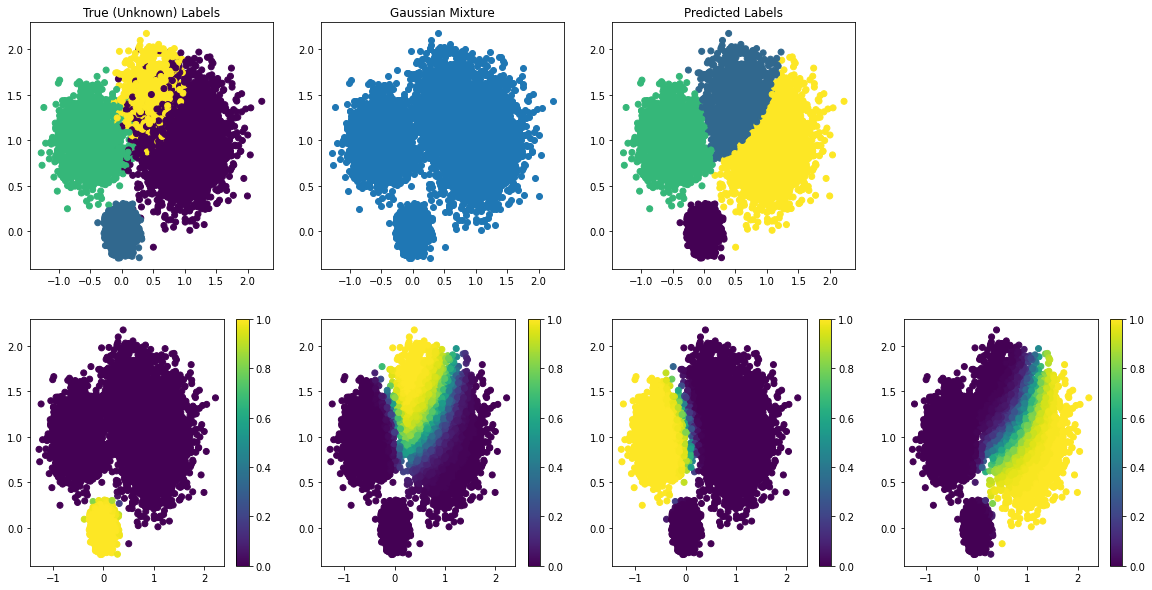

In [18]:
Nclusters = 4
GMM = GaussianMixture(n_components=Nclusters).fit(X)
labels = GMM.predict(X)
prob = GMM.predict_proba(X).round(2)

fig = plt.figure(figsize=(20,10))
fig.add_subplot(2,Nclusters,1)
plt.scatter(X[:,0],X[:,1], c=L)
plt.title('True (Unknown) Labels');
fig.add_subplot(2,Nclusters,2)
plt.scatter(X[:,0],X[:,1])
plt.title('Gaussian Mixture');
fig.add_subplot(2,Nclusters,3)
plt.scatter(X[:,0],X[:,1], c=labels)
plt.title('Predicted Labels');
for i in range(Nclusters):
    ax = fig.add_subplot(2,Nclusters,Nclusters+i+1)
    p1 = ax.scatter(X[:,0], X[:,1], c=prob[:,i])
    fig.colorbar(p1, ax=ax)

### Code from Scratch

In [19]:
# To be shared after solutions to HW3 are released.

### Performance on "mixture.txt"

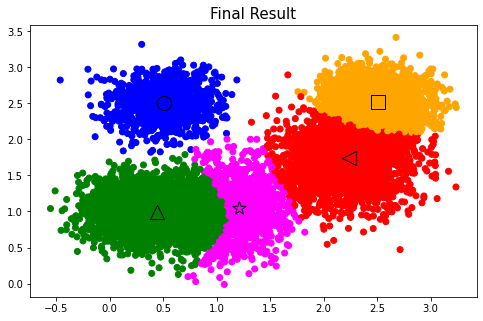

In [21]:
X = np.loadtxt('mixture.txt')
NumComponents = 5
EM_Means, EM_Sigs, EM_Ps, pZ_X = EM_GaussianMixture(X, NumComponents,50,0.1, False)

### GMM on Synthetic Data

In [22]:
from sklearn import datasets

# Create synthetically generate data
n_samples = 1500
X1, T1 = datasets.make_blobs(n_samples=n_samples,centers=3,cluster_std=1)               # Blobs data
X2, T2 = datasets.make_blobs(n_samples=n_samples,cluster_std=[1.0, 2.5, 0.5],centers=3) # Different Variance Blobs data
X3, T3 = datasets.make_moons(n_samples=n_samples, noise=.05)                            # Moons data
X4, T4 = datasets.make_circles(n_samples, noise=.05, factor=0.5)                        # Circles data
X5     = np.dot(X1, [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]])             # Anisotropicly distributed data
T5     = T1
X6     = np.vstack((X1[T1 == 0][:500], X1[T1 == 1][:100], X1[T1 == 2][:10]))            # Unevenly sized Blobs data
T6     = np.hstack((np.zeros(500),np.ones(100),2*np.ones(10)))
T6     = T6.astype(int)

colors=np.array(['magenta','orange','blue','green','red','cyan'])

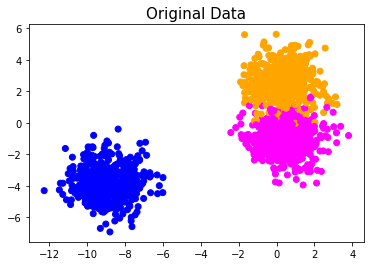

Iteration t=0
Component:  1 , Pi:  0.3333333333333333 , Mean:  [-0.76091526 -0.38489976] , Sigma:  [[0.5 0. ]
 [0.  0.5]]
Component:  2 , Pi:  0.3333333333333333 , Mean:  [ 0.32730034 -0.32655784] , Sigma:  [[0.5 0. ]
 [0.  0.5]]
Component:  3 , Pi:  0.3333333333333333 , Mean:  [-1.30162574  2.6654307 ] , Sigma:  [[0.5 0. ]
 [0.  0.5]]


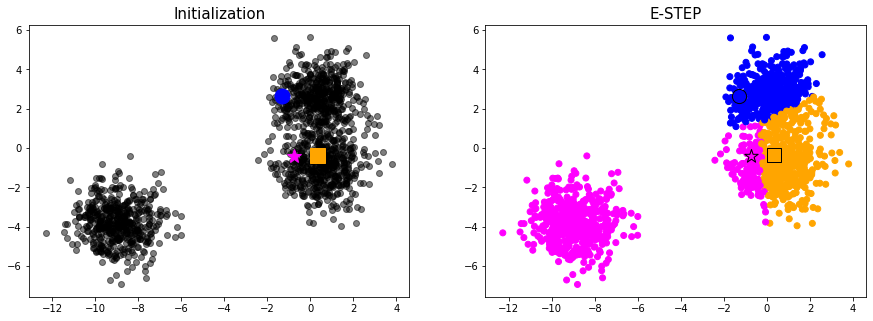

t =  1 : 	 39.654072653145285
Component:  1 , Pi:  0.43929848394406834 , Mean:  [-6.890724   -3.06889794] , Sigma:  [[14.46593087  4.64808172]
 [ 4.64808172  2.67091492]]
Component:  2 , Pi:  0.2946279134632376 , Mean:  [ 0.94347916 -0.51089456] , Sigma:  [[0.68624005 0.12320939]
 [0.12320939 1.77658092]]
Component:  3 , Pi:  0.2660736025926925 , Mean:  [0.19977044 2.89446221] , Sigma:  [[0.86357517 0.21266028]
 [0.21266028 0.6662475 ]]


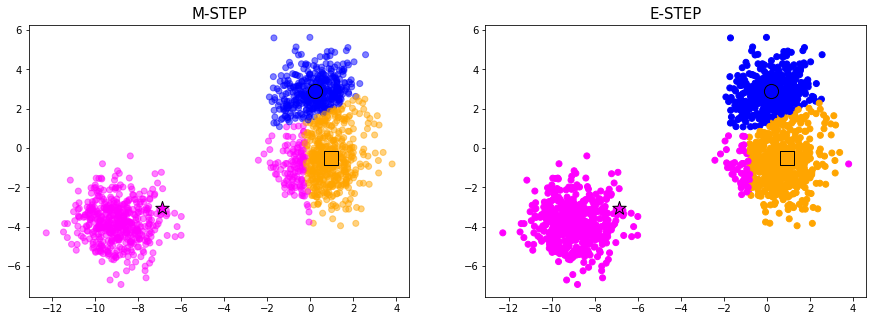

t =  2 : 	 9.682531643985133
Component:  1 , Pi:  0.38984134049032604 , Mean:  [-7.72125491 -3.35641428] , Sigma:  [[10.26399264  3.14531462]
 [ 3.14531462  2.09105919]]
Component:  2 , Pi:  0.33338721122158493 , Mean:  [ 0.75643852 -0.60431317] , Sigma:  [[0.72481408 0.11208748]
 [0.11208748 1.72983381]]
Component:  3 , Pi:  0.2767714482880893 , Mean:  [0.22372889 2.82324391] , Sigma:  [[0.82900258 0.17141476]
 [0.17141476 0.74422486]]


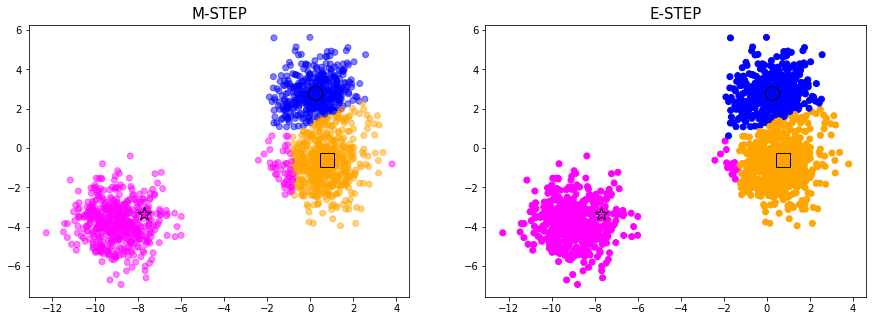

t =  3 : 	 11.583489946812522
Component:  1 , Pi:  0.35440263220205337 , Mean:  [-8.48534322 -3.61458486] , Sigma:  [[4.72926338 1.26297385]
 [1.26297385 1.46358538]]
Component:  2 , Pi:  0.36144970019120365 , Mean:  [ 0.66681678 -0.66555902] , Sigma:  [[0.8472085  0.11113931]
 [0.11113931 1.58821636]]
Component:  3 , Pi:  0.28414766760674315 , Mean:  [0.24723616 2.79093784] , Sigma:  [[0.84735874 0.15175499]
 [0.15175499 0.77742907]]


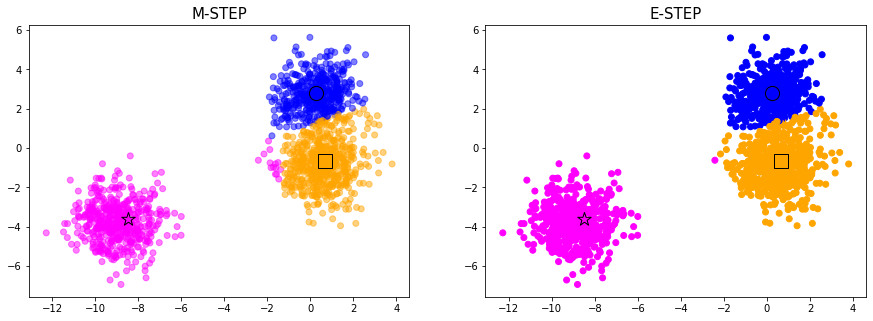

t =  4 : 	 7.5470621217800655
Component:  1 , Pi:  0.3345902389990369 , Mean:  [-8.94204443 -3.77310274] , Sigma:  [[1.20543173 0.03964146]
 [0.03964146 1.05895616]]
Component:  2 , Pi:  0.3754059381905863 , Mean:  [ 0.58128004 -0.71932387] , Sigma:  [[0.97485267 0.10000394]
 [0.10000394 1.45912801]]
Component:  3 , Pi:  0.2900038228103773 , Mean:  [0.26809693 2.7721558 ] , Sigma:  [[0.85391931 0.13183733]
 [0.13183733 0.79017812]]


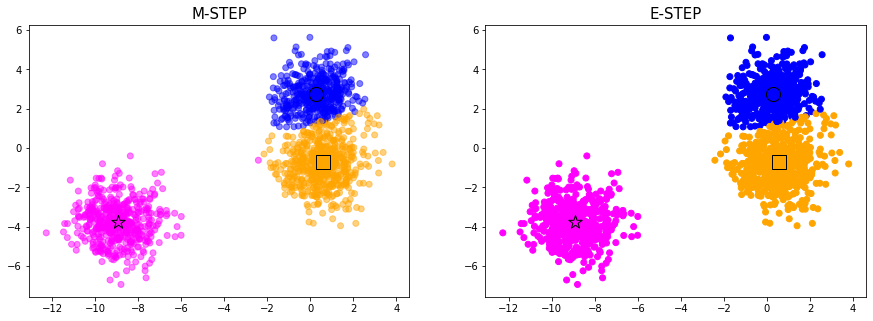

t =  5 : 	 0.7410482782838105
Component:  1 , Pi:  0.333333333358579 , Mean:  [-8.96897854 -3.78424988] , Sigma:  [[ 1.01544817 -0.0394558 ]
 [-0.0394558   1.02863151]]
Component:  2 , Pi:  0.37184153534439823 , Mean:  [ 0.56036777 -0.75446207] , Sigma:  [[1.00284922 0.07130373]
 [0.07130373 1.37566942]]
Component:  3 , Pi:  0.29482513129702315 , Mean:  [0.28944559 2.75896067] , Sigma:  [[0.85294615 0.10587782]
 [0.10587782 0.7926578 ]]


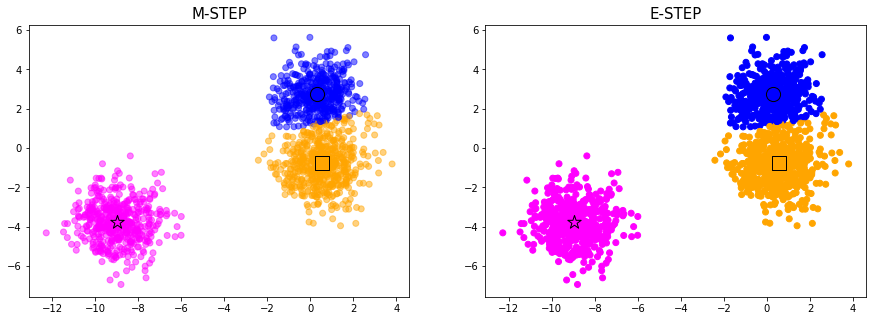

t =  6 : 	 0.22787252940875677
Component:  1 , Pi:  0.33333333332815984 , Mean:  [-8.96897854 -3.78424988] , Sigma:  [[ 1.01544816 -0.0394558 ]
 [-0.0394558   1.02863151]]
Component:  2 , Pi:  0.36746315412828806 , Mean:  [ 0.55202202 -0.78406146] , Sigma:  [[1.00558279 0.05234151]
 [0.05234151 1.31335869]]
Component:  3 , Pi:  0.2992035125435524 , Mean:  [0.30365985 2.74389929] , Sigma:  [[0.85812281 0.0884787 ]
 [0.0884787  0.80160914]]


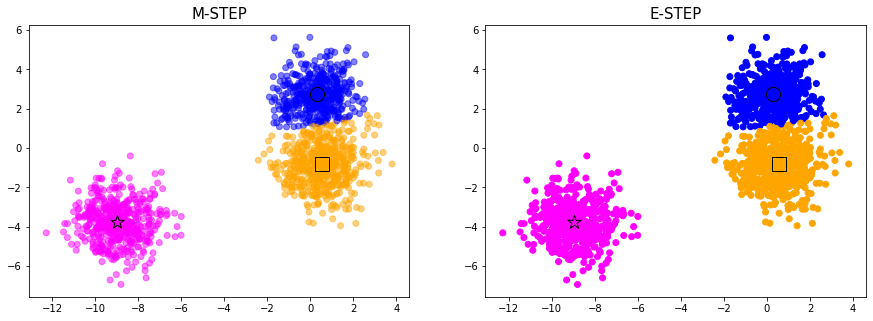

t =  7 : 	 0.17923978547968422
Component:  1 , Pi:  0.3333333333288583 , Mean:  [-8.96897854 -3.78424988] , Sigma:  [[ 1.01544816 -0.0394558 ]
 [-0.0394558   1.02863151]]
Component:  2 , Pi:  0.36357311982482937 , Mean:  [ 0.54684195 -0.8092058 ] , Sigma:  [[1.004981   0.04034758]
 [0.04034758 1.26352384]]
Component:  3 , Pi:  0.3030935468463125 , Mean:  [0.31306114 2.72878157] , Sigma:  [[0.86449485 0.07671162]
 [0.07671162 0.81389471]]


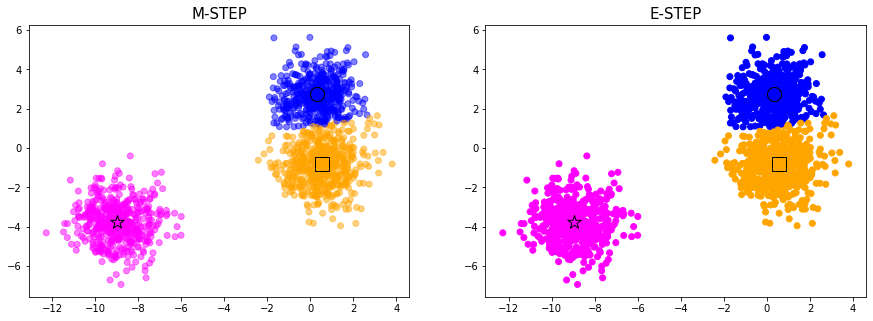

t =  8 : 	 0.14655132106037674
Component:  1 , Pi:  0.33333333332953224 , Mean:  [-8.96897854 -3.78424988] , Sigma:  [[ 1.01544816 -0.0394558 ]
 [-0.0394558   1.02863151]]
Component:  2 , Pi:  0.36018637339346793 , Mean:  [ 0.54337026 -0.83051825] , Sigma:  [[1.00350649 0.03223314]
 [0.03223314 1.22290507]]
Component:  3 , Pi:  0.3064802932770002 , Mean:  [0.31972458 2.71473234] , Sigma:  [[0.87023324 0.06813317]
 [0.06813317 0.82695829]]


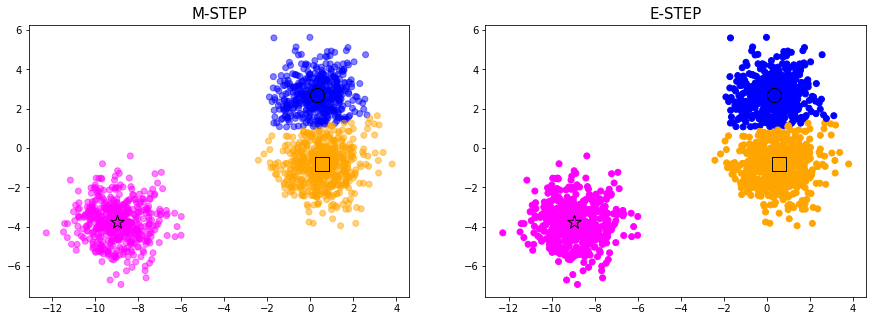

t =  9 : 	 0.12123072908848065
Component:  1 , Pi:  0.3333333333300548 , Mean:  [-8.96897854 -3.78424988] , Sigma:  [[ 1.01544816 -0.0394558 ]
 [-0.0394558   1.02863151]]
Component:  2 , Pi:  0.3572782681682619 , Mean:  [ 0.5408767  -0.84848082] , Sigma:  [[1.00184011 0.02637047]
 [0.02637047 1.18963482]]
Component:  3 , Pi:  0.30938839850168326 , Mean:  [0.32470627 2.70215163] , Sigma:  [[0.8751364  0.06155457]
 [0.06155457 0.83963194]]


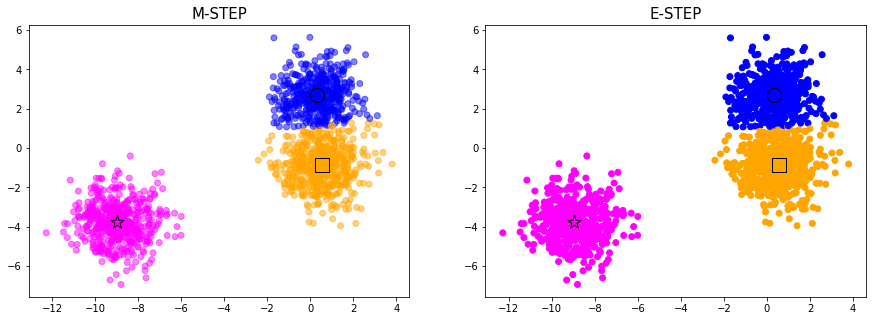

t =  10 : 	 0.10090093745042744
Component:  1 , Pi:  0.33333333333045306 , Mean:  [-8.96897854 -3.78424988] , Sigma:  [[ 1.01544816 -0.0394558 ]
 [-0.0394558   1.02863151]]
Component:  2 , Pi:  0.3548056786881412 , Mean:  [ 0.53898311 -0.86352923] , Sigma:  [[1.00022301 0.02190376]
 [0.02190376 1.16239818]]
Component:  3 , Pi:  0.3118609879814053 , Mean:  [0.32857453 2.69112109] , Sigma:  [[0.87926361 0.05633389]
 [0.05633389 0.85139115]]


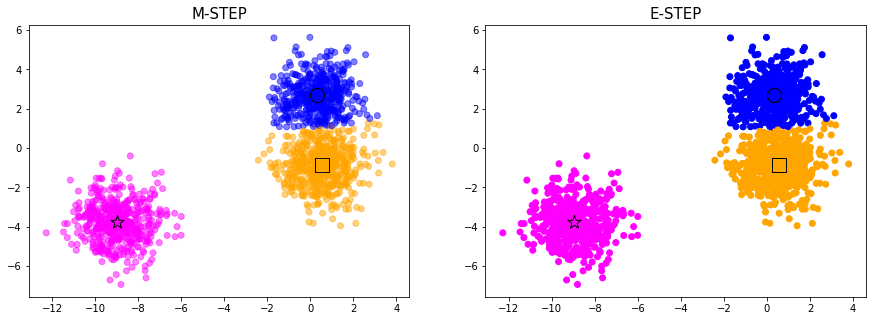

t =  11 : 	 0.08415729595576565
Component:  1 , Pi:  0.33333333333075926 , Mean:  [-8.96897854 -3.78424988] , Sigma:  [[ 1.01544816 -0.0394558 ]
 [-0.0394558   1.02863151]]
Component:  2 , Pi:  0.35271846306580074 , Mean:  [ 0.53748834 -0.87607269] , Sigma:  [[0.99874971 0.01837465]
 [0.01837465 1.14014011]]
Component:  3 , Pi:  0.3139482036034404 , Mean:  [0.33165275 2.68158127] , Sigma:  [[0.88271207 0.05210138]
 [0.05210138 0.86201468]]


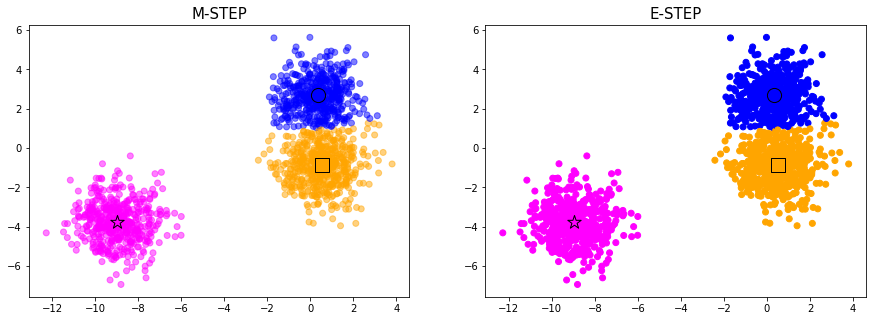

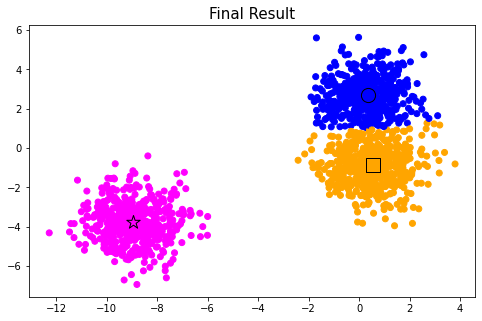

In [23]:
NumComponents = 3
plt.scatter(X1[:,0],X1[:,1],c=colors[T1])
plt.title('Original Data',size=15);plt.show()

EM_Means, EM_Sigs, EM_Ps, pZ_X = EM_GaussianMixture(X1, NumComponents,50,0.1)

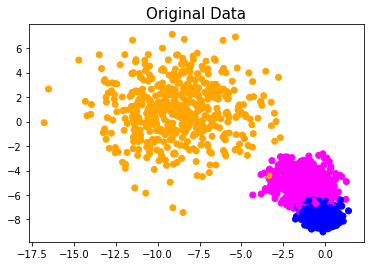

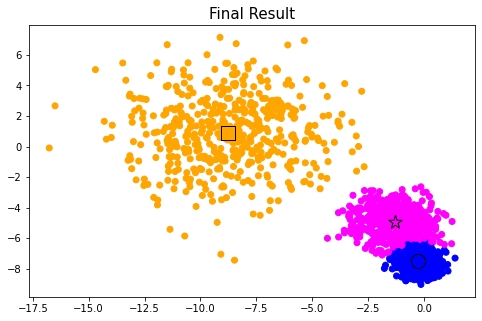

In [24]:
NumComponents = 3
plt.scatter(X2[:,0],X2[:,1],c=colors[T2])
plt.title('Original Data',size=15);plt.show()

EM_Means, EM_Sigs, EM_Ps, pZ_X = EM_GaussianMixture(X2, NumComponents,50,0.1, False)

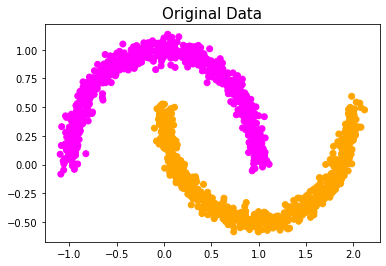

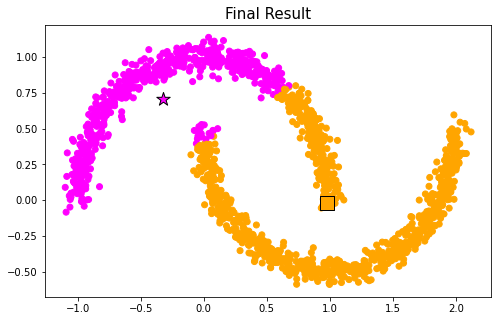

In [26]:
NumComponents = 2
plt.scatter(X3[:,0],X3[:,1],c=colors[T3])
plt.title('Original Data',size=15);plt.show()

EM_Means, EM_Sigs, EM_Ps, pZ_X = EM_GaussianMixture(X3, NumComponents,50,0.1, False)

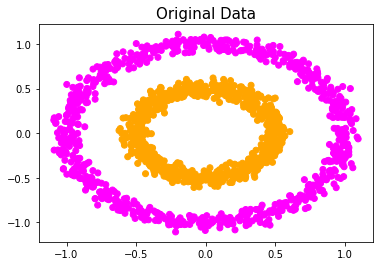

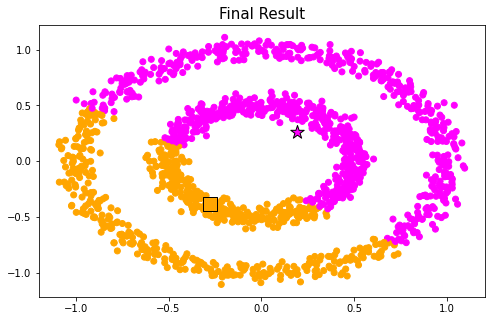

In [27]:
NumComponents = 2
plt.scatter(X4[:,0],X4[:,1],c=colors[T4])
plt.title('Original Data',size=15);plt.show()

EM_Means, EM_Sigs, EM_Ps, pZ_X = EM_GaussianMixture(X4, NumComponents,50,0.1, False)

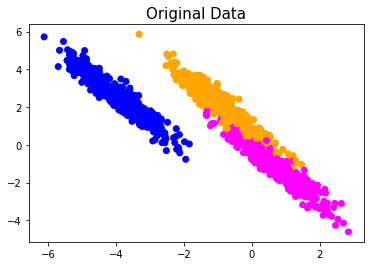

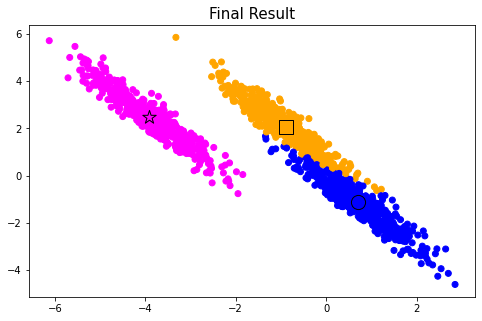

In [30]:
NumComponents = 3
plt.scatter(X5[:,0],X5[:,1],c=colors[T5])
plt.title('Original Data',size=15);plt.show()

EM_Means, EM_Sigs, EM_Ps, pZ_X = EM_GaussianMixture(X5, NumComponents,50,0.1, False)

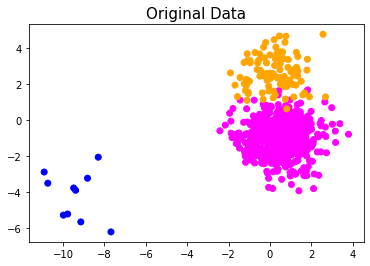

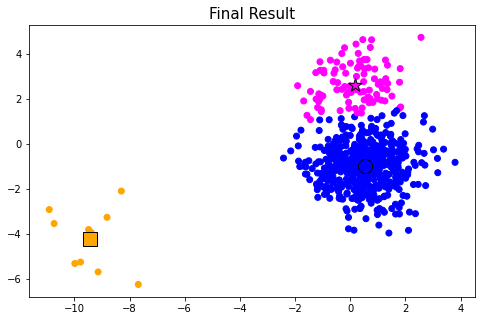

In [31]:
NumComponents = 3
plt.scatter(X6[:,0],X6[:,1],c=colors[T6])
plt.title('Original Data',size=15);plt.show()

EM_Means, EM_Sigs, EM_Ps, pZ_X = EM_GaussianMixture(X6, NumComponents,50,0.1, False)